### 1. 라이브러리 호출

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

---------------

### 2. 데이터 불러오기

In [2]:
# 건물정보 데이터셋
building = pd.read_csv('data/building_info.csv')

# 날씨/전력사용량 데이터셋 (건물/시간대별)
train = pd.read_csv('data/train.csv')

# 날씨/전력사용량 데이터셋 (건물/시간대별)
test = pd.read_csv('data/test.csv')

In [3]:
# 한글폰트 사용: 'NanumGothic' 폰트를 사용합니다.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 문제 해결

---------------

### 3-1. 결측치 시각화

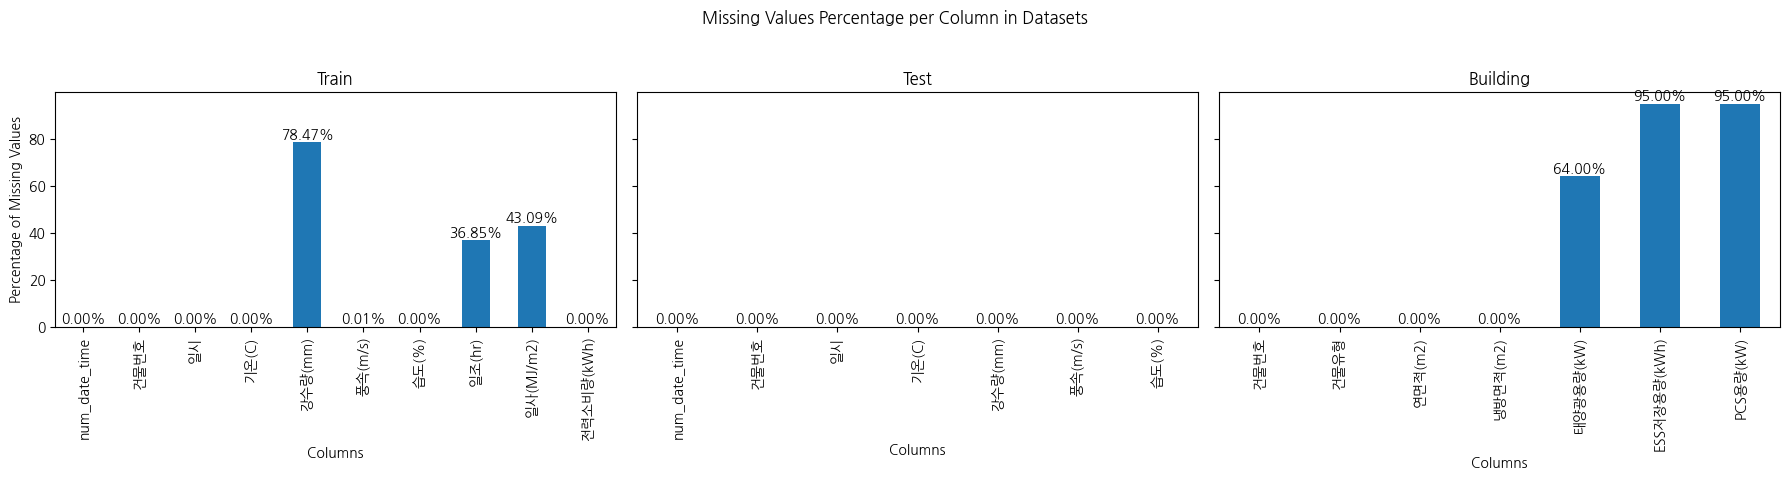

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# '-'를 결측치로 변환하고, 결측치 비율을 계산하는 함수
def calculate_missing_values(df):
    df.replace('-', pd.NA, inplace=True)
    return df.isnull().mean() * 100

# 각 데이터프레임에 함수 적용
datasets = {'Train': train, 'Test': test, 'Building': building}
missing_data = {name: calculate_missing_values(df) for name, df in datasets.items()}

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 서브플롯들 공유 Y 축 설정
fig.suptitle('Missing Values Percentage per Column in Datasets')

for ax, (title, data) in zip(axes, missing_data.items()):
    bars = data.plot.bar(ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Percentage of Missing Values')
    ax.set_xlabel('Columns')
    
    # 각 막대 위에 값 추가
    for p in bars.patches:
        ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 상위 제목이 잘리지 않도록 조정
plt.show()

### 3-2. 결측치가 있는 컬럼 추출하기

In [5]:
# 각 데이터셋에서 결측치가 포함된 컬럼 목록을 반환하는 함수
def find_columns_with_missing_values(df):
    missing_columns = df.columns[df.isnull().any()].tolist()
    return missing_columns

# train, test, building 데이터셋에서 결측치가 있는 컬럼 추출
missing_columns_train = find_columns_with_missing_values(train)
missing_columns_test = find_columns_with_missing_values(test)
missing_columns_building = find_columns_with_missing_values(building)

# 출력
print("Train 데이터 결측치 컬럼:", missing_columns_train)
print("Test 데이터 결측치 컬럼:", missing_columns_test)
print("Building 데이터 결측치 컬럼:", missing_columns_building)

Train 데이터 결측치 컬럼: ['강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
Test 데이터 결측치 컬럼: []
Building 데이터 결측치 컬럼: ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']


### 3-3. 값이 0인 행 출력하기

In [6]:
# 데이터셋에서 값이 0인 셀을 포함하는 행을 찾는 코드
def find_rows_with_any_zeros(df):
    zero_rows = df[(df == 0).any(axis=1)]
    return zero_rows

# train, test, building 데이터셋에서 값이 0인 셀을 포함하는 행 추출
rows_with_zeros_train = find_rows_with_any_zeros(train)
rows_with_zeros_test = find_rows_with_any_zeros(test)
rows_with_zeros_building = find_rows_with_any_zeros(building)

In [7]:
# building 데이터에서 값이 0인 행 출력하기
rows_with_zeros_building

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
64,65,아파트,183839.000,0.0,<NA>,<NA>,<NA>
65,66,아파트,105073.000,0.0,<NA>,<NA>,<NA>
67,68,아파트,389395.928,0.0,<NA>,<NA>,<NA>


In [8]:
# train 데이터에서 값이 0인 행 출력하기
rows_with_zeros_train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
6,1_20220601 06,1,20220601 06,16.3,NaN,1.0,50.0,0.0,0.05,1314.72
30,1_20220602 06,1,20220602 06,17.8,NaN,2.4,80.0,0.0,0.04,1390.08
31,1_20220602 07,1,20220602 07,18.4,NaN,2.6,77.0,0.0,0.27,1739.04
54,1_20220603 06,1,20220603 06,19.1,NaN,2.1,79.0,0.0,0.03,1451.04
55,1_20220603 07,1,20220603 07,19.6,NaN,1.7,77.0,0.0,0.34,1863.84
...,...,...,...,...,...,...,...,...,...,...
203989,100_20220824 13,100,20220824 13,24.7,NaN,1.4,75.0,0.0,NaN,1096.80
203990,100_20220824 14,100,20220824 14,24.9,NaN,1.2,76.0,0.0,NaN,1092.00
203991,100_20220824 15,100,20220824 15,25.1,NaN,1.2,74.0,0.0,NaN,1120.32
203992,100_20220824 16,100,20220824 16,25.6,NaN,1.4,72.0,0.0,NaN,1137.60


### 3-4. 결측치 처리 코드

In [9]:
# building 데이터셋에서 결측치가 많은 컬럼 삭제
building.drop(columns=['ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1, inplace=True)
train.drop(columns=['num_date_time', '강수량(mm)', '일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)
test.drop(columns=['num_date_time', '강수량(mm)'], axis=1, inplace=True)

# 결측치르 0값으로 처리
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)
building.fillna(0, inplace=True)

### 3-5. Train, Test 데이터 병합

In [10]:
# train,test 데이터셋을 building 데이터와 병합
train = pd.merge(building, train, on = '건물번호')
test = pd.merge(building, test, on = '건물번호')

--------------------

### 4. 태양광용량 시각화

In [11]:
# 태양광용량 전처리
train['태양광용량(kW)'] = train['태양광용량(kW)'].apply(lambda x : 1 if x != 0 else x)
train['태양광용량(kW)'] = train['태양광용량(kW)'].astype('int')
test['태양광용량(kW)'] = test['태양광용량(kW)'].apply(lambda x : 1 if x != 0 else x)
test['태양광용량(kW)'] = test['태양광용량(kW)'].astype('int')

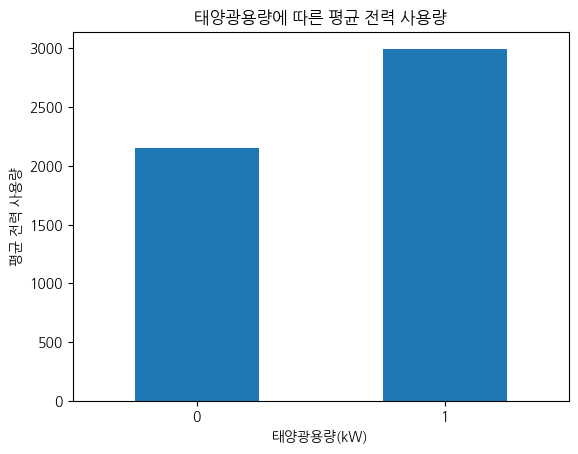

In [12]:
# 태양광용량 시각화
train.groupby('태양광용량(kW)')['전력소비량(kWh)'].mean().plot(kind='bar')
plt.xlabel('태양광용량(kW)')
plt.ylabel('평균 전력 사용량')
plt.title('태양광용량에 따른 평균 전력 사용량')
plt.xticks(rotation=0)
plt.show()

C:\Users\NT930QCG\AppData\Local\Temp\ipykernel_34604\1733416817.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  building_type_zero_solar = train.groupby('건물유형').apply(lambda x: (x['태양광용량(kW)'] == 0).mean() * 100)  # 백분율로 변환


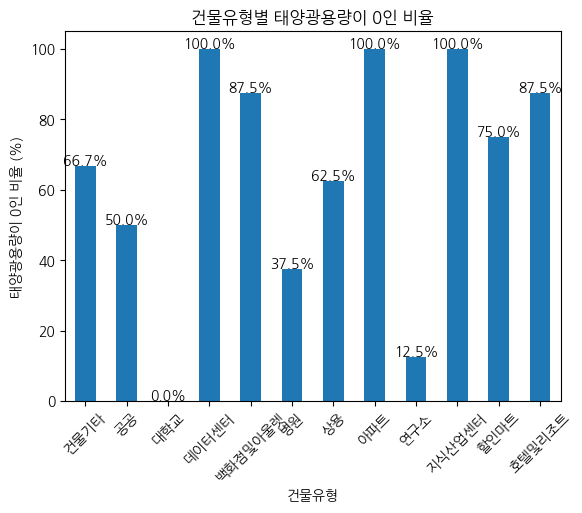

In [13]:
# 건물유형별 태양광용량이 0인 항목의 비율을 계산
building_type_zero_solar = train.groupby('건물유형').apply(lambda x: (x['태양광용량(kW)'] == 0).mean() * 100)  # 백분율로 변환

# 비율을 막대 그래프로 시각화
ax = building_type_zero_solar.plot(kind='bar')
plt.xlabel('건물유형')
plt.ylabel('태양광용량이 0인 비율 (%)')
plt.title('건물유형별 태양광용량이 0인 비율')
plt.xticks(rotation=45)  # x축 라벨 회전

# 막대 위에 비율 표시
for i, v in enumerate(building_type_zero_solar):
    ax.text(i, v + 0.5, f"{v:.1f}%", color='black', ha='center')

plt.show()

--------------

### 5. 건물유형별, 건물종류별 개수 파악

In [17]:
# 건물유형별 개수
train['건물유형'].value_counts()

건물유형
건물기타       30600
공공         16320
대학교        16320
백화점및아울렛    16320
병원         16320
상용         16320
아파트        16320
연구소        16320
지식산업센터     16320
할인마트       16320
호텔및리조트     16320
데이터센터      10200
Name: count, dtype: int64

In [20]:
# 건물번호별 개수
train['건물번호'].value_counts()

건물번호
1      2040
64     2040
74     2040
73     2040
72     2040
       ... 
31     2040
30     2040
29     2040
28     2040
100    2040
Name: count, Length: 100, dtype: int64

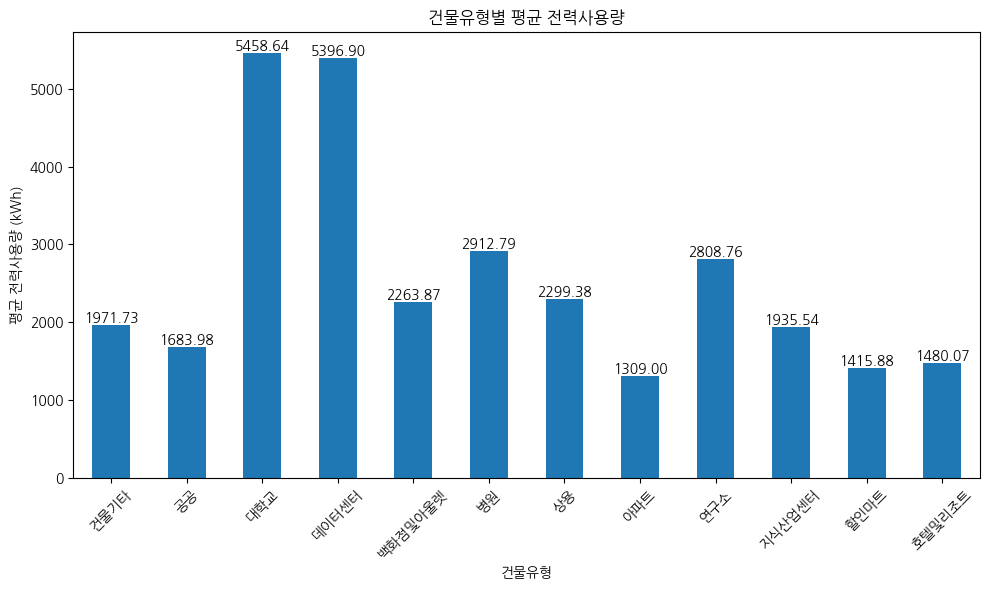

In [27]:
# '건물유형'별 '전력사용량' 평균을 계산
average_energy = train.groupby('건물유형')['전력소비량(kWh)'].mean()

# 평균 전력사용량을 막대 그래프로 시각화
average_energy.plot(kind='bar', figsize=(10,6))

# 그래프 타이틀과 라벨 설정
plt.title('건물유형별 평균 전력사용량')
plt.xlabel('건물유형')
plt.ylabel('평균 전력사용량 (kWh)')
plt.xticks(rotation=45)  # x축 레이블 회전

# 막대 위에 평균 전력사용량 값을 표시
for index, value in enumerate(average_energy):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# 그래프 표시
plt.tight_layout()  # 그래프의 레이아웃을 자동으로 조정
plt.show()


------------------------

### 중간전처리

In [65]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# 건물정보 파일
building = pd.read_csv('data/building_info.csv')

# Train 데이터셋
train = pd.read_csv('data/train.csv')

# Test 데이터셋
test = pd.read_csv('data/test.csv')

# Submission 파일
submission = pd.read_csv('data/submission.csv')

# 태양광이 없는 곳이므로 0값처리
building['태양광용량(kW)'] = building['태양광용량(kW)'].replace('-', 0)
building['태양광용량(kW)'] = building['태양광용량(kW)'].astype('float64')

# 대부분 결측치이고, 해당 기능이 없는 것이므로 0값처리
building['ESS저장용량(kWh)'] = building['ESS저장용량(kWh)'].replace('-', 0)
building['ESS저장용량(kWh)'] = building['ESS저장용량(kWh)'].astype('float64')
building['PCS용량(kW)'] = building['PCS용량(kW)'].replace('-', 0)
building['PCS용량(kW)'] = building['PCS용량(kW)'].astype('float64')

# '연면적 : 냉방면적 (=1.27)' 비율을 적용하여 냉방면적 결측치 처리
building['냉방면적(m2)'][64] = building['연면적(m2)'][64]/1.27
building['냉방면적(m2)'][65] = building['연면적(m2)'][65]/1.27
building['냉방면적(m2)'][67] = building['연면적(m2)'][67]/1.27


# 평일/휴일 컬럼 만들기 - 평일과 휴일의 전력사용량 차이가 있음
train['일시'] = pd.to_datetime(train['일시'], format = '%Y%m%d %H')
def is_holiday(row):
    if row['일시'].date() in [pd.to_datetime('2022-06-06').date(), pd.to_datetime('2022-08-15').date()]:
        return 1
    elif row['일시'].dayofweek >= 5:  # 토요일(5) 또는 일요일(6)인 경우
        return 1
    else:
        return 0
train['휴일'] = train.apply(is_holiday, axis=1)

# 일시를 년, 월, 일 컬럼으로 분리(train) - 기존의 num_date_time을 사용하기 어려움
train['년'] = train['일시'].dt.year
train['월'] = train['일시'].dt.month
train['일'] = train['일시'].dt.day
train['시'] = train['일시'].dt.hour
train.drop(['num_date_time', '일시', '년'], axis=1, inplace=True)

# 시간 데이터 표준화 - 시간의 주기성을 반영하기 위해 사용
train['sin_time'] = np.sin(2*np.pi*train['시']/24)
train['cos_time'] = np.cos(2*np.pi*train['시']/24)

# 공통된 건물번호 컬럼을 기준으로 데이터 병합
train = pd.merge(building, train, on = '건물번호')

# 건물유형 컬럼 처리 숫자로 변경
train['건물유형'] = train['건물유형'].replace('건물기타', 1)
train['건물유형'] = train['건물유형'].replace('공공', 2)
train['건물유형'] = train['건물유형'].replace('대학교', 3)
train['건물유형'] = train['건물유형'].replace('데이터센터', 4)
train['건물유형'] = train['건물유형'].replace('백화점및아울렛', 5)
train['건물유형'] = train['건물유형'].replace('병원', 6)
train['건물유형'] = train['건물유형'].replace('상용', 7)
train['건물유형'] = train['건물유형'].replace('아파트', 8)
train['건물유형'] = train['건물유형'].replace('연구소', 9)
train['건물유형'] = train['건물유형'].replace('지식산업센터', 10)
train['건물유형'] = train['건물유형'].replace('할인마트', 11)
train['건물유형'] = train['건물유형'].replace('호텔및리조트', 12)

# 기상청에서 결측치 처리에 사용되는 interpolate를 이용해 결측치 처리
train['강수량(mm)'] = train['강수량(mm)'].interpolate(method = 'linear')
train['풍속(m/s)'] = train['풍속(m/s)'].interpolate(method = 'linear')
train['습도(%)'] = train['습도(%)'].interpolate(method = 'linear')
train['일조(hr)'] = train['일조(hr)'].interpolate(method = 'linear')
train['일사(MJ/m2)'] = train['일사(MJ/m2)'].interpolate(method = 'linear')

# 파생변수 생성: 불쾌지수/냉방효율/체감온도
train['불쾌지수'] = 1.8 * train['기온(C)'] -0.55 * (1-train['습도(%)']/100) * (1.8 * train['습도(%)']-26) + 32
train['냉방효율'] = train['냉방면적(m2)'] / train['연면적(m2)']
train['체감온도'] = 13.12 + 0.6125 * train['기온(C)'] - 11.37*(train['풍속(m/s)']**0.16) + 0.3965 * (train['풍속(m/s)']**0.16)*train['기온(C)']

# 태양광용량은 유무로 0과 1로 처리
train['태양광용량(kW)'] = train['태양광용량(kW)'].apply(lambda x : 1 if x != 0 else x)
train['태양광용량(kW)'] = train['태양광용량(kW)'].astype('int')


# 기타 미처리 결측치 처리
train['강수량(mm)'].fillna(0, inplace = True)
train['일조(hr)'].fillna(0, inplace = True)
train['일사(MJ/m2)'].fillna(0, inplace = True)

# 필요없거나 영향 없는 컬럼 삭제
train.drop(['ESS저장용량(kWh)', 'PCS용량(kW)', '강수량(mm)', '일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)

# 주말/공휴일 컬럼 만들기
test['일시'] = pd.to_datetime(test['일시'], format = '%Y%m%d %H')
def is_holiday(row):
    if row['일시'].date() in [pd.to_datetime('2022-06-06').date(), pd.to_datetime('2022-08-15').date()]:
        return 1
    elif row['일시'].dayofweek >= 5:  # 토요일(5) 또는 일요일(6)인 경우
        return 1
    else:
        return 0
test['휴일'] = test.apply(is_holiday, axis=1)

# 일시를 년, 월, 일 컬럼으로 분리(test)
test['년'] = test['일시'].dt.year
test['월'] = test['일시'].dt.month
test['일'] = test['일시'].dt.day
test['시'] = test['일시'].dt.hour

# test 시 컬럼 전처리
test['sin_time'] = np.sin(2*np.pi*test['시']/24)
test['cos_time'] = np.cos(2*np.pi*test['시']/24)

# 사용하지 않는 컬럼 삭제
test.drop(['num_date_time', '일시', '년'], axis=1, inplace=True)

# 공통된 건물번호 컬럼을 기준으로 데이터 병합
test = pd.merge(building, test, on = '건물번호')

# 건물유형 컬럼 처리 숫자로 변경
test['건물유형'] = test['건물유형'].replace('건물기타', 1)
test['건물유형'] = test['건물유형'].replace('공공', 2)
test['건물유형'] = test['건물유형'].replace('대학교', 3)
test['건물유형'] = test['건물유형'].replace('데이터센터', 4)
test['건물유형'] = test['건물유형'].replace('백화점및아울렛', 5)
test['건물유형'] = test['건물유형'].replace('병원', 6)
test['건물유형'] = test['건물유형'].replace('상용', 7)
test['건물유형'] = test['건물유형'].replace('아파트', 8)
test['건물유형'] = test['건물유형'].replace('연구소', 9)
test['건물유형'] = test['건물유형'].replace('지식산업센터', 10)
test['건물유형'] = test['건물유형'].replace('할인마트', 11)
test['건물유형'] = test['건물유형'].replace('호텔및리조트', 12)

# 파생변수 생성: 불쾌지수/냉방효율/체감온도
test['불쾌지수'] = 1.8 * test['기온(C)'] -0.55 * (1-test['습도(%)']/100) * (1.8 * test['습도(%)']-26) + 32
test['냉방효율'] = test['냉방면적(m2)'] / test['연면적(m2)']
test['체감온도'] = 13.12 + 0.6125 * test['기온(C)'] - 11.37*(test['풍속(m/s)']**0.16) + 0.3965 * (test['풍속(m/s)']**0.16) * test['기온(C)']

# 필요없거나 영향 없는 컬럼 삭제
test.drop(['ESS저장용량(kWh)', 'PCS용량(kW)', '강수량(mm)'], axis=1, inplace=True)

# 평가지표(SMAPE) 설정
def smape(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))/2) * 100
scoring = make_scorer(smape, greater_is_better = False)

train= train.drop(['연면적(m2)', '냉방면적(m2)', '시'], axis=1)

C:\Users\NT930QCG\AppData\Local\Temp\ipykernel_34604\2392394543.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  building['냉방면적(m2)'][64] = building['연면적(m2)'][64]/1.27
C:\Users\NT930QCG\AppData\Local\Temp\ipykernel_34604\2392394543.py:3

-----------------------------

### 6. 건물유형별 전력사용량과의 상관관계

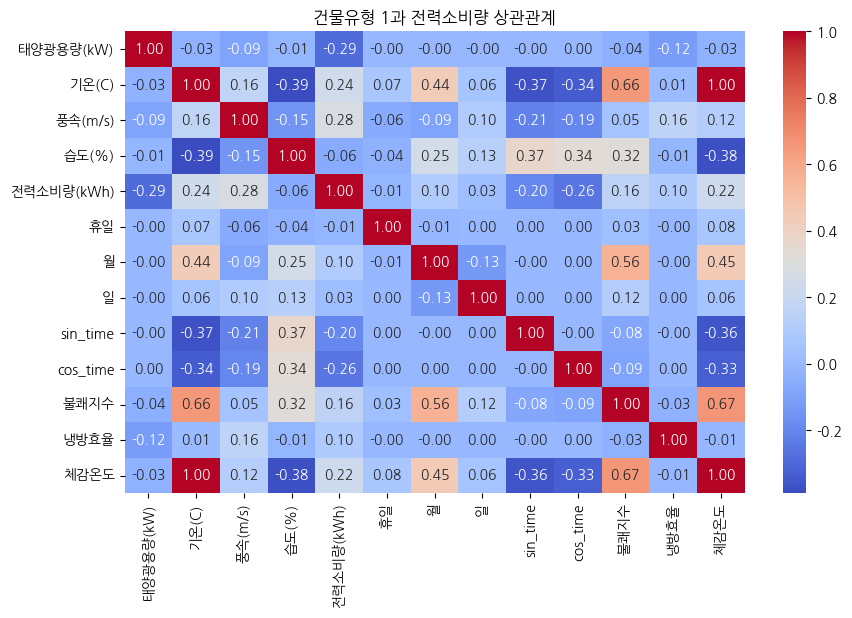

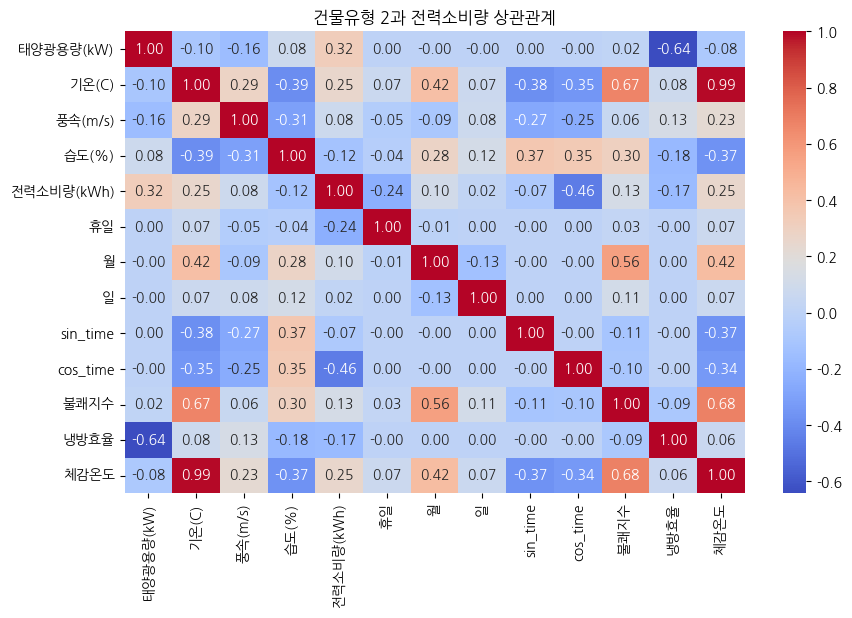

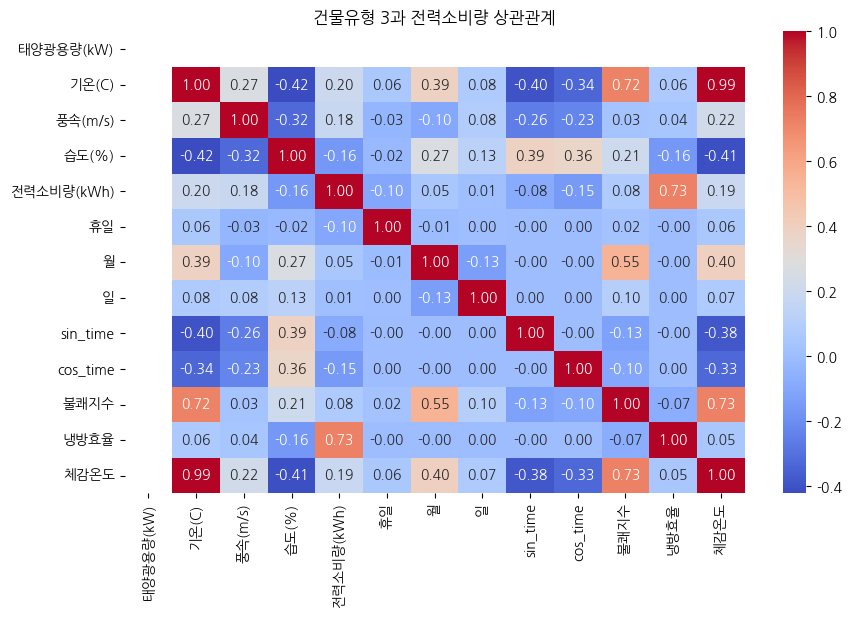

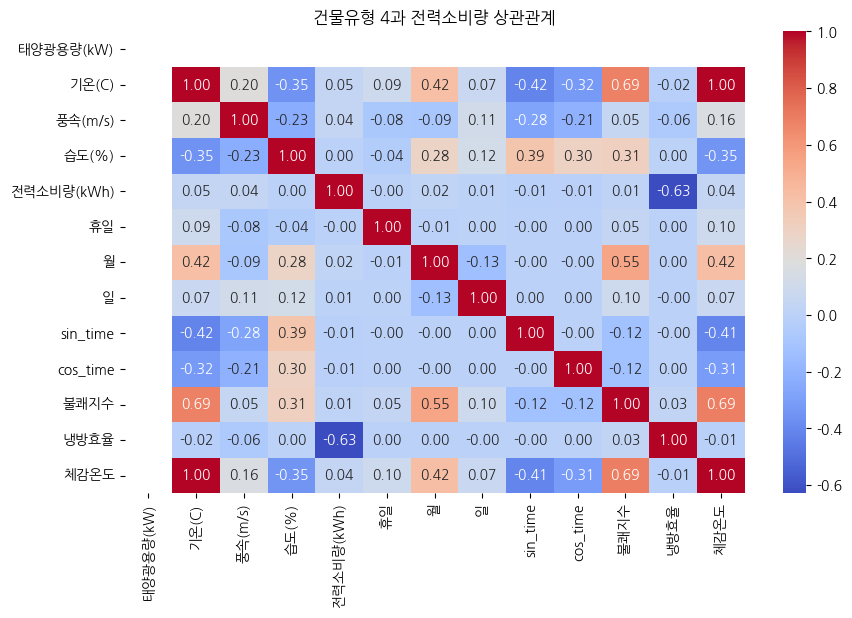

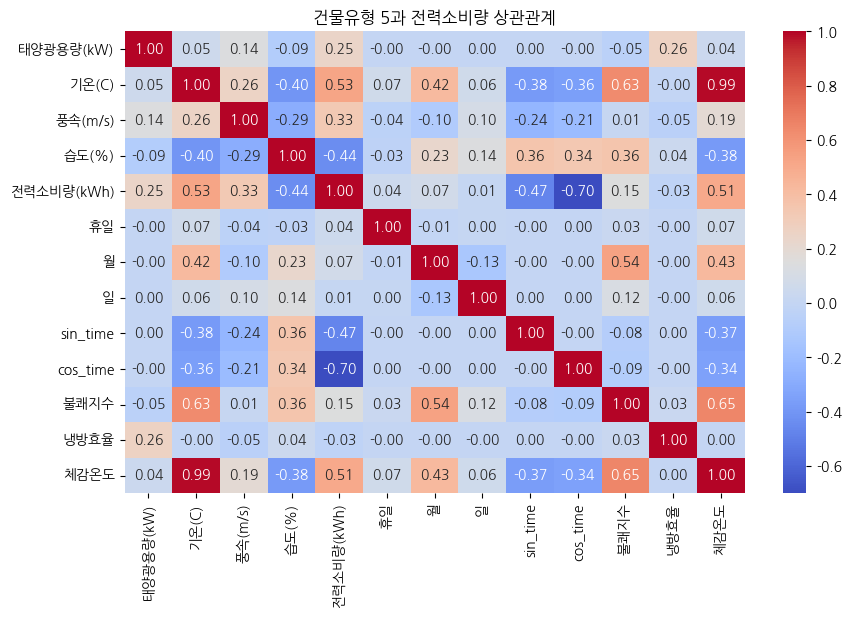

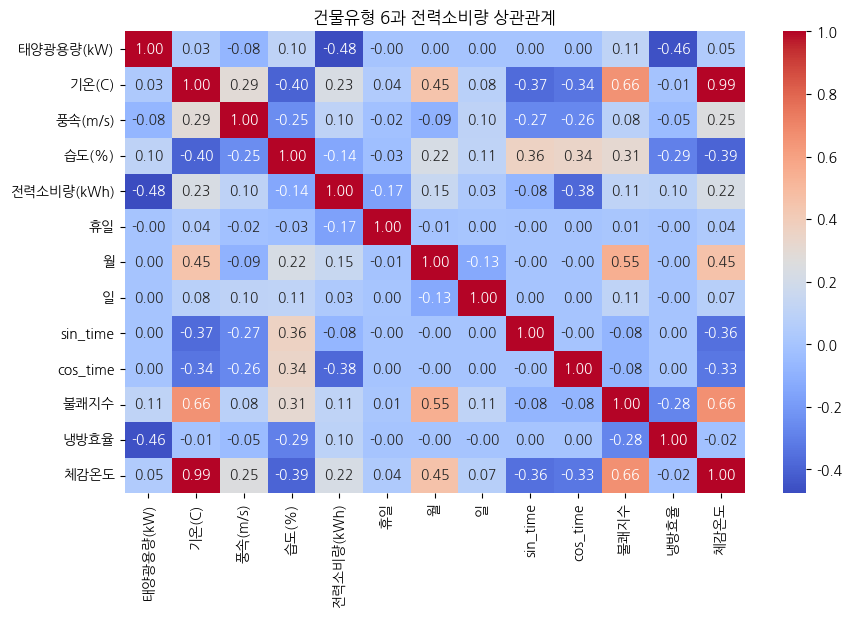

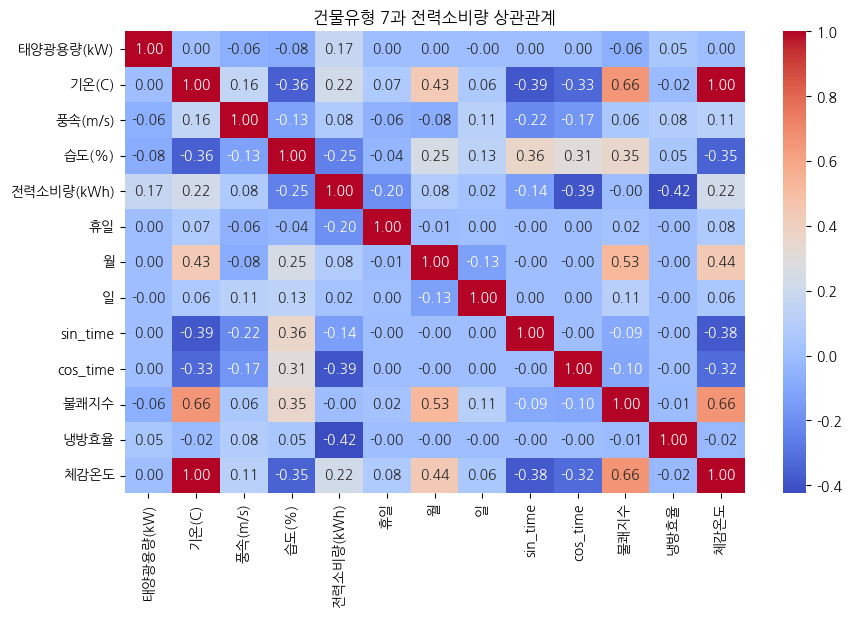

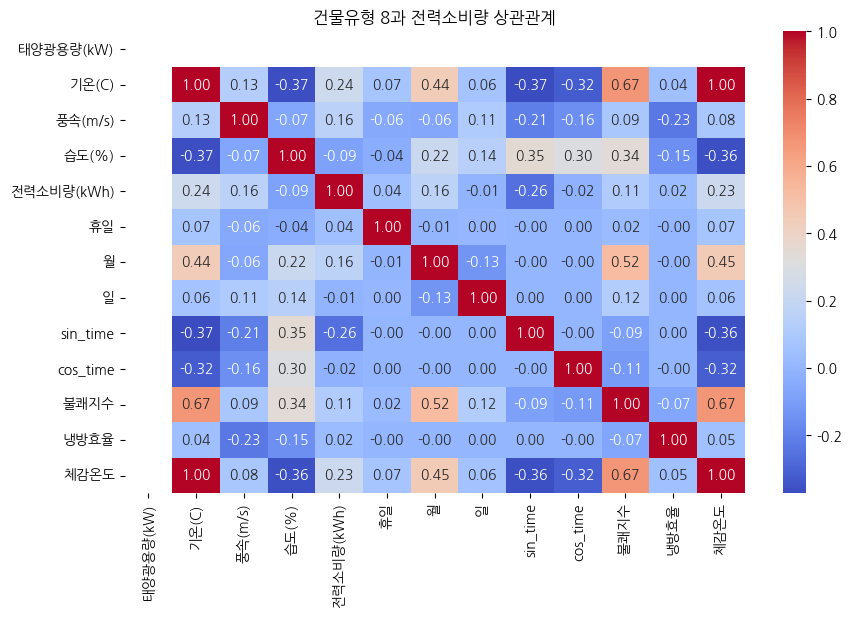

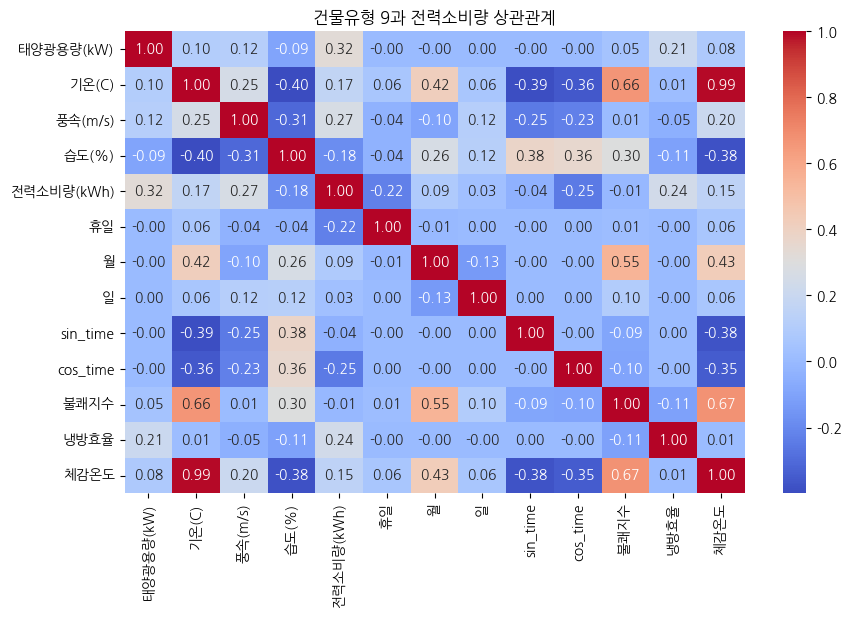

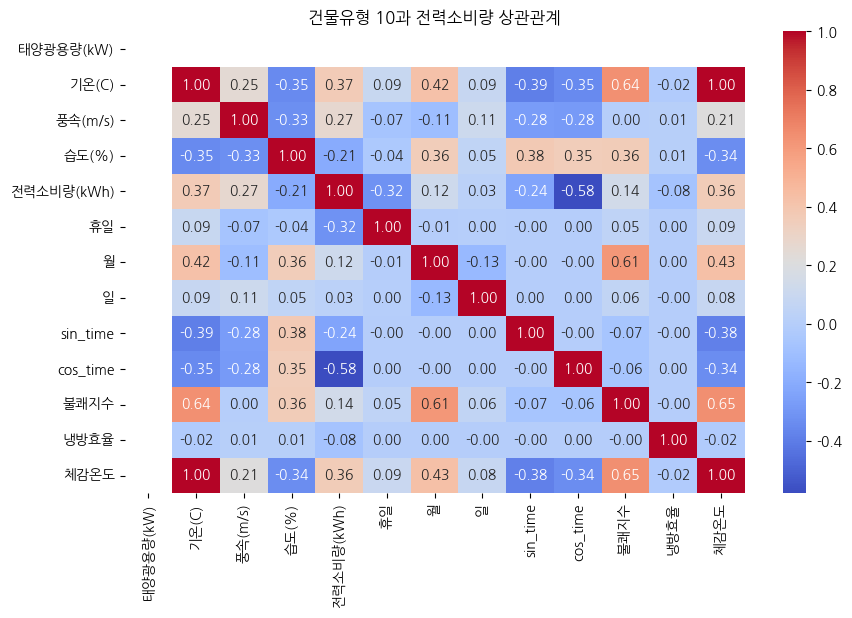

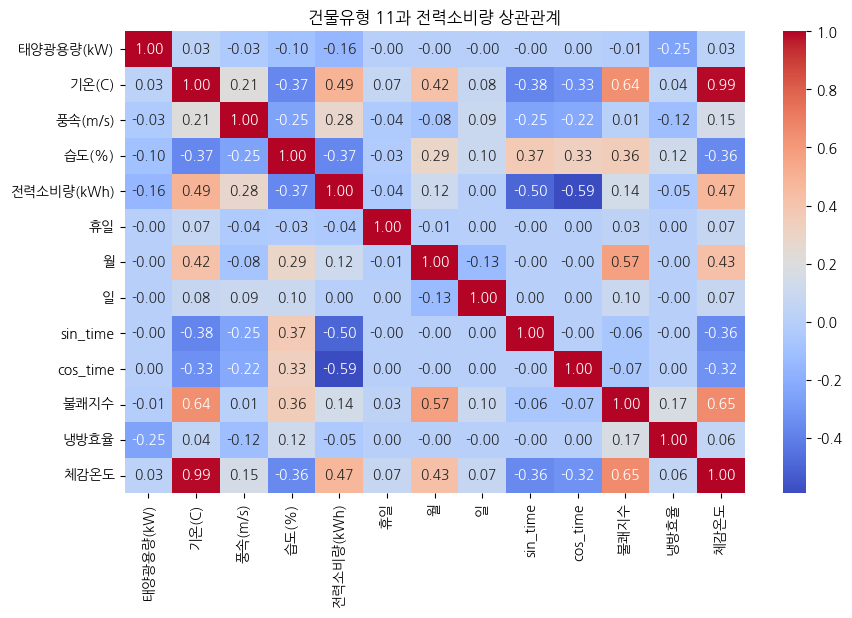

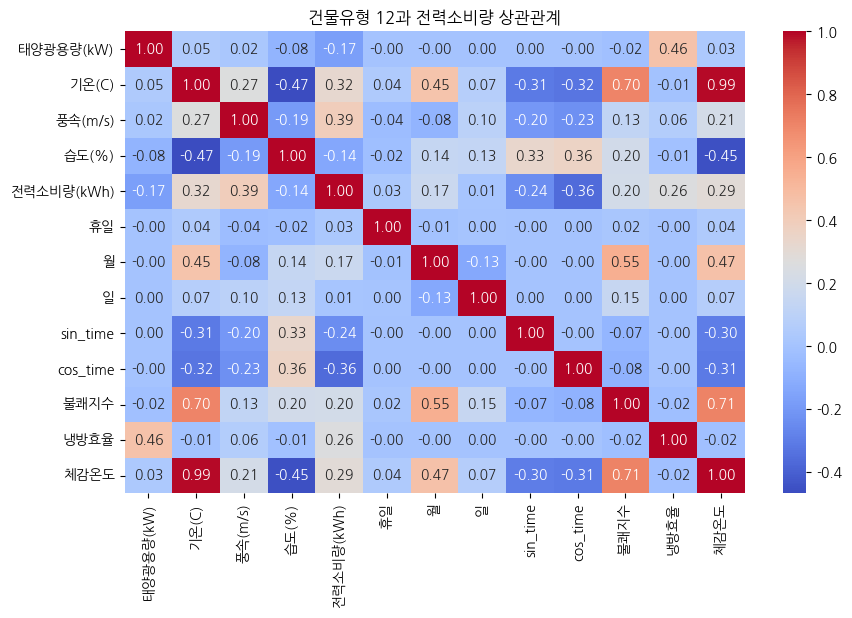

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# train 데이터셋을 반복 처리
for building_type in range(1, 13):  # 건물 유형 1부터 12까지
    # 건물유형별 데이터 필터링
    building = train[train['건물유형'] == building_type]

    # 불필요한 컬럼 제거
    building = building.drop(['건물번호', '건물유형'], axis=1)

    # 수치형 변수들 간의 상관관계 행렬을 계산
    correlation_matrix = building.corr()

    # 히트맵을 그림
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'건물유형 {building_type}과 전력소비량 상관관계')
    plt.show()